## EDA For SierraLeone

## 1. Objective
This notebook performs an exploratory data analysis on solar energy measurements from [Country Name].  
The goal is to:
- Clean the raw dataset
- Understand distribution, trends, and anomalies
- Prepare data for cross-country comparison



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

df = pd.read_csv("../data/sierraleone-bumbuna.csv", parse_dates=["Timestamp"])
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2,2021-10-30 00:03:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
3,2021-10-30 00:04:00,-0.7,0.0,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.1,22.3,22.6,NaN
4,2021-10-30 00:05:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


## 2. Dataset Overview
Columns analyzed include:
- `GHI`, `DNI`, `DHI`: Types of solar irradiance
- `ModA`, `ModB`: Sensor measurements
- `Tamb`, `RH`: Temperature and humidity
- `WS`, `WSgust`, `WD`: Wind metrics
- `Cleaning`: Indicates cleaning activity
- `Precipitation`, `BP`, `TModA`, `TModB`: Environmental factors

We start by inspecting the dataset using descriptive statistics and checking for missing values.

- `df.describe()` provides central tendency, spread, and range.
- `df.isna().sum()` shows the count of missing entries per column.

Columns with over 5% missing data are flagged for cleaning or imputation.
This step helps identify anomalies such as negative irradiance or extreme sensor values.


In [4]:
df.describe()
df.isna().sum()


Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

## Outlier detectiom

We detect outliers using Z-scores for numerical columns like `GHI`, `DNI`, `ModA`, `WS`, etc. A value with a Z-score beyond ±3 is treated as an outlier.

Outliers are removed to prevent skewed statistical analysis and misleading graphs.
This is especially important for modeling and comparisons across countries.


In [5]:
from scipy.stats import zscore

z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[z_cols].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)


df_clean = df[~outliers]


df_clean.fillna(df_clean.median(), inplace=True)


/tmp/ipykernel_73441/3491700759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.fillna(df_clean.median(), inplace=True)


## Cleaning

We handle missing data by:
- Dropping non-critical rows with excessive nulls
- Filling missing values with median (a robust choice)

After cleaning, the dataset is stored as `[country]_clean.csv` in the `data/` folder, which is excluded from Git commits. This cleaned version becomes the source for all further analysis.


In [6]:
df_clean.to_csv('../data/sierraleone-malanville_clean.csv', index=False)


## Time Series Analysis
Line plots are used to visualize `GHI`, `DNI`, `DHI`, and `Tamb` over time.

We look for:
- Seasonal patterns (e.g., daily or monthly sunlight trends)
- Irregularities or sudden spikes in measurements
- Consistency across time (important for long-term solar investment)

Example Insight: A daily spike in GHI around noon confirms typical solar behavior.


/tmp/ipykernel_73441/195264045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>],
      dtype=object)

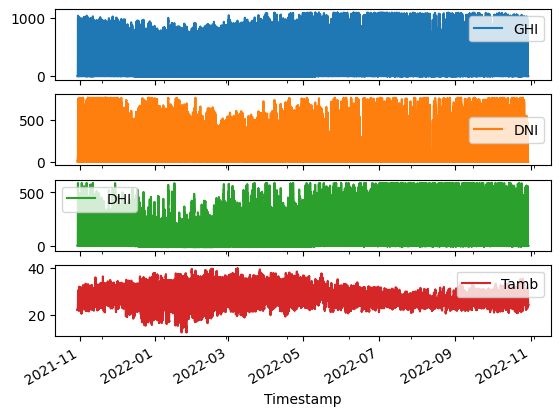

In [7]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(subplots=True)


## cleaning Impact

We compare sensor readings (`ModA`, `ModB`) before and after cleaning events.

If cleaning makes a noticeable difference in sensor output, it reinforces the need for routine maintenance.

This can affect the estimated efficiency of solar farms.


<Axes: xlabel='Cleaning'>

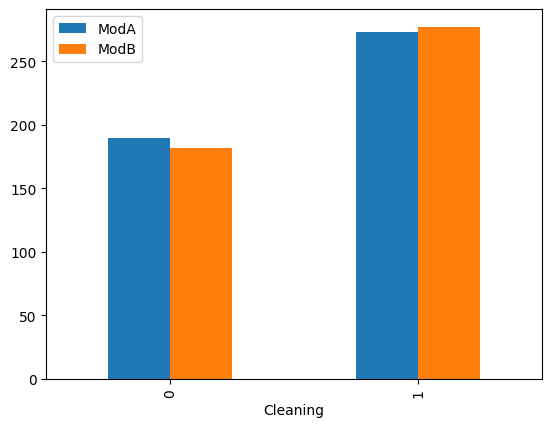

In [8]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')


## Correlation Matrix

A correlation matrix visualizes relationships between variables like:

- GHI vs TModA
- RH vs Tamb
- DNI vs DHI

Strong correlations (positive or negative) help identify predictors or redundancies.

For instance, a high correlation between `Tamb` and `GHI` suggests temperature rises with sunlight, which can impact panel efficiency.


<Axes: >

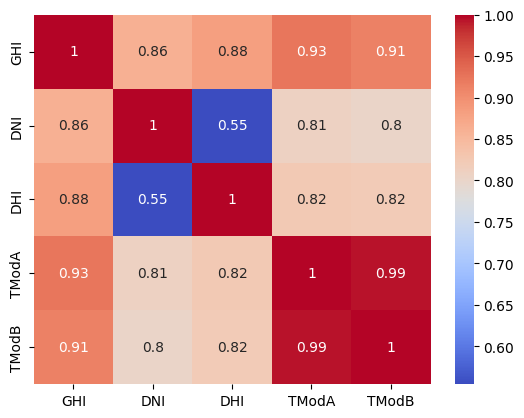

In [9]:
import seaborn as sns
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')


<Axes: >

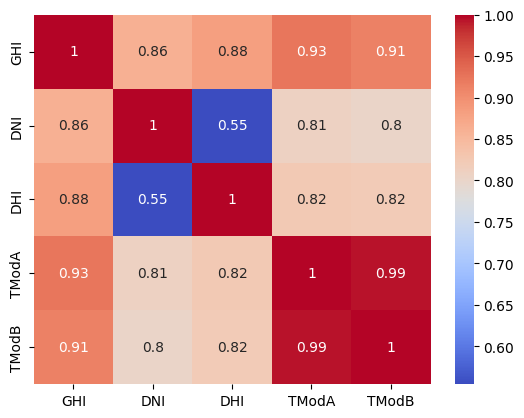

In [10]:
import seaborn as sns
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')


## scatter plots
Scatter plots help visualize how two variables interact.

Key pairs:
- Wind Speed (WS) vs GHI
- Humidity (RH) vs Temperature (Tamb)
- WSgust vs DNI

Patterns in these plots help us understand:
- If high humidity suppresses irradiance
- Whether wind helps clean the panels naturally

We look for linear, non-linear, or no clear relationships.


<Axes: xlabel='WS', ylabel='GHI'>

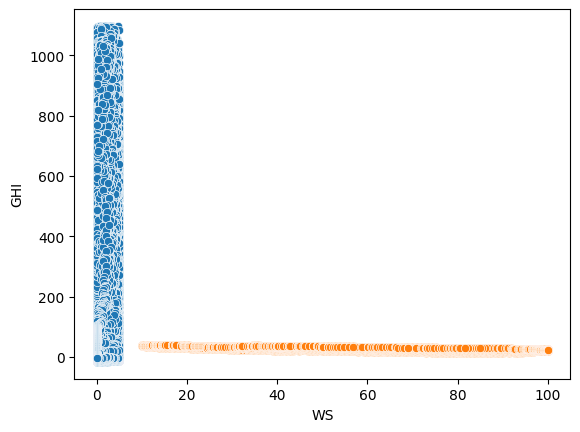

In [11]:
sns.scatterplot(x='WS', y='GHI', data=df_clean)
sns.scatterplot(x='RH', y='Tamb', data=df_clean)


We analyze the distribution of wind-related variables:
- Wind speed (WS)
- Wind direction (WD)

Wind roses or histograms help assess:
- Dominant wind directions (which affect panel orientation)
- Wind speed distributions (which may help natural panel cleaning or cause cooling)

Additionally, histograms for variables like GHI provide a general sense of spread and skewness.


<Axes: >

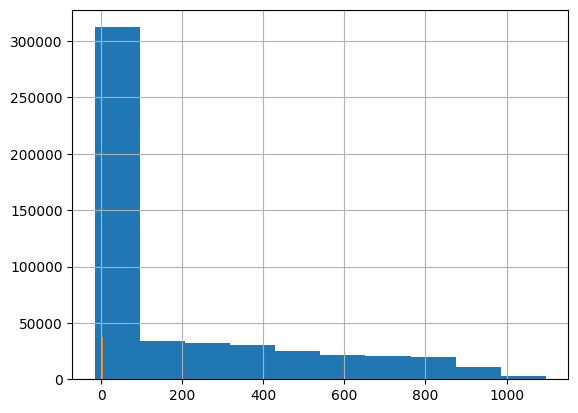

In [12]:
df_clean['GHI'].hist()
df_clean['WS'].hist()


## Bubble Chart
A bubble chart plots:
- GHI on X-axis
- Ambient Temperature on Y-axis
- Bubble size = RH (humidity)

This helps visualize how combinations of solar radiation, temperature, and humidity occur.

It can highlight:
- Ideal conditions for solar energy (e.g., high GHI, moderate Tamb, low RH)
- Outliers or special weather events

<Axes: xlabel='RH', ylabel='Tamb'>

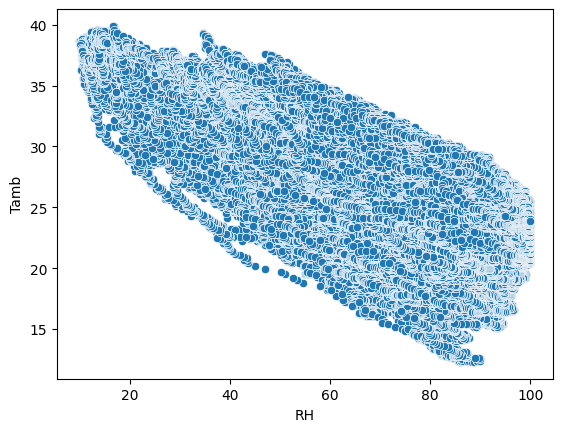

In [13]:
sns.scatterplot(x='RH', y='Tamb', data=df_clean)


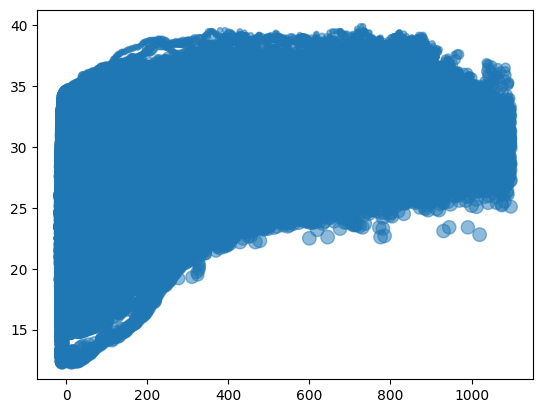

In [14]:
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH'], alpha=0.5)
